In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import choices
import torch
import imageio.v2 as imageio
from scipy.optimize import linear_sum_assignment
from ipywidgets import interact
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


In [2]:
# Display routines from (https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html)

def load_image(fname):

    img = imageio.imread(fname)

    return img/255.0

def RGB_cloud(fname,sampling,dtype = torch.FloatTensor):

    A = load_image(fname)

    A = A[::sampling,::sampling]

    return torch.from_numpy(A).type(dtype).view(-1,3)

def display_cloud(ax,x):

    x_ = x#.detach().cpu().numpy()

    ax.scatter(x_[:,0],x_[:,1],x_[:,2],s = 25*500/len(x_), c= x_)


def display_image(ax,x):

    W =  int(np.sqrt(len(x)))

    x_ = x.reshape(W,W,3)#view(W,W,3).detach().cpu().numpy()

    ax.imshow(x_)

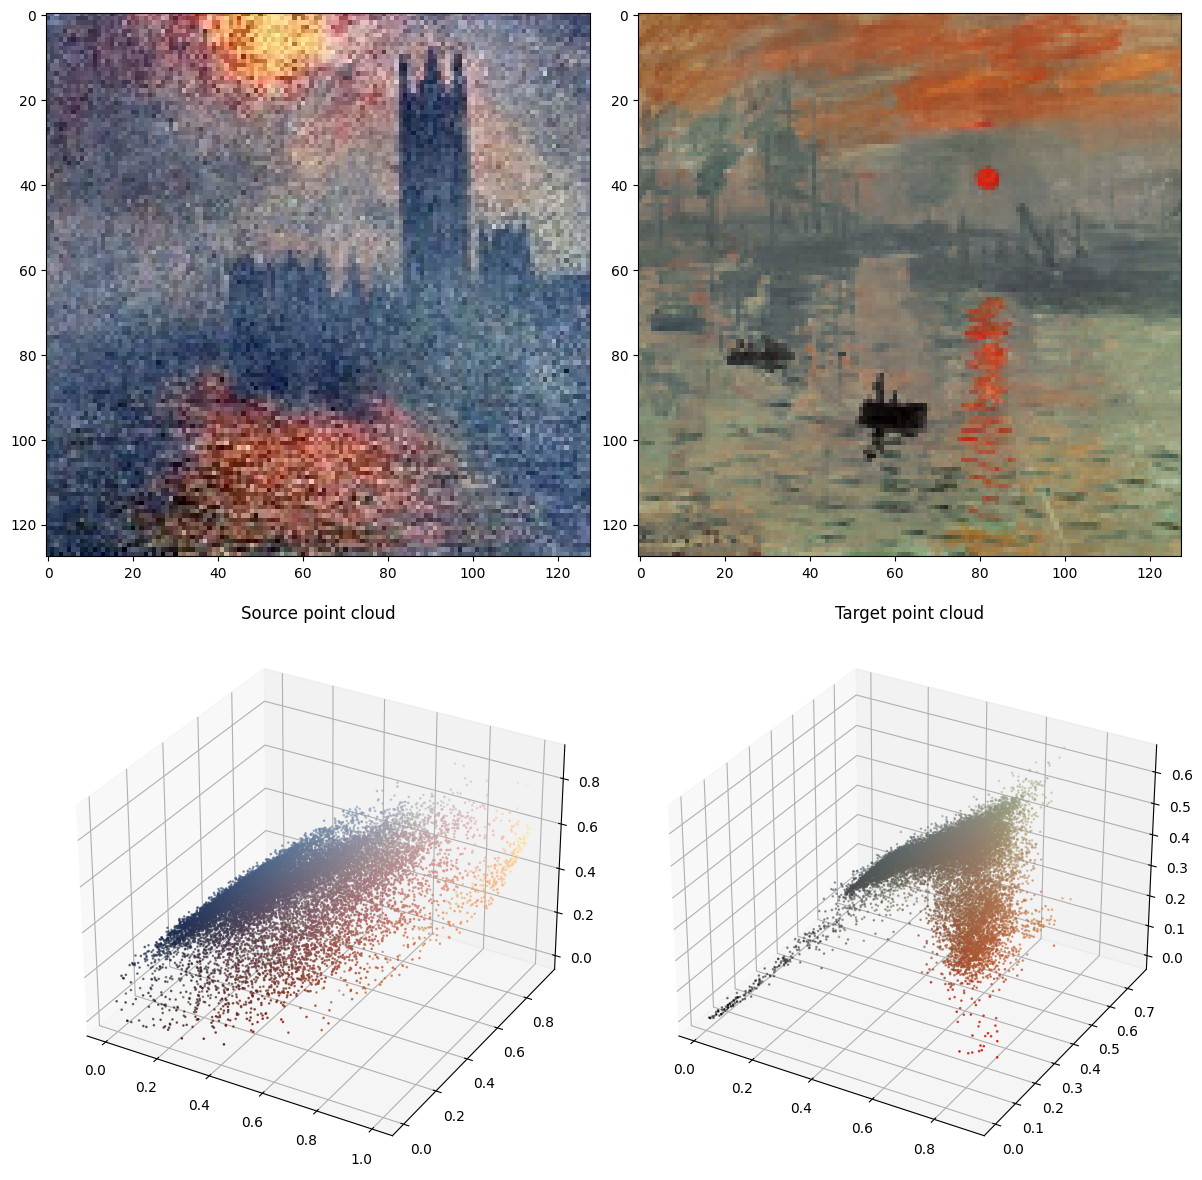

In [3]:
sampling = 2 #if not use_cuda else 1

X_i = RGB_cloud('monet.png',sampling)

Y_j = RGB_cloud('monet2.jpg',sampling)

Z = RGB_cloud('vangogh.jpg',sampling).numpy()
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
display_image(ax,X_i)
ax = fig.add_subplot(2,2,2)
display_image(ax,Y_j)

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, X_i)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, Y_j)
ax.set_title("Target point cloud")
plt.tight_layout()

#plt.savefig('target01.png')

# Sinkhorn algorithm

In [4]:
# Cost matrix

def cost_mat(x,y,n):
# cost_mat = lambda   np.tile(np.sum(y**2,0),(n,1)) + np.tile(np.sum(x**2,0)[:,np.newaxis],(1,n)) -2*np.dot(np.transpose(x),y)

    x2 = np.sum(x**2,0)
    y2 = np.sum(y**2,0)
    return np.tile(y2,(n,1)) + np.tile(x2[:,np.newaxis],(1,n)) -2*np.dot(np.transpose(x),y)

In [5]:
n = X_i.size()[0]

In [6]:
np.shape(X_i.numpy()[:,0].T.reshape(16384,1))

(16384, 1)

In [7]:
C = cost_mat(X_i.numpy()[:,0].T.reshape(16384,1),Y_j.numpy()[:,0].T.reshape(16384,1),n)

In [8]:
row_ind, col_ind = linear_sum_assignment(C)

In [9]:
col_ind[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
X = X_i.numpy()

Y = Y_j.numpy()

In [11]:
X1 = X[col_ind.tolist()]

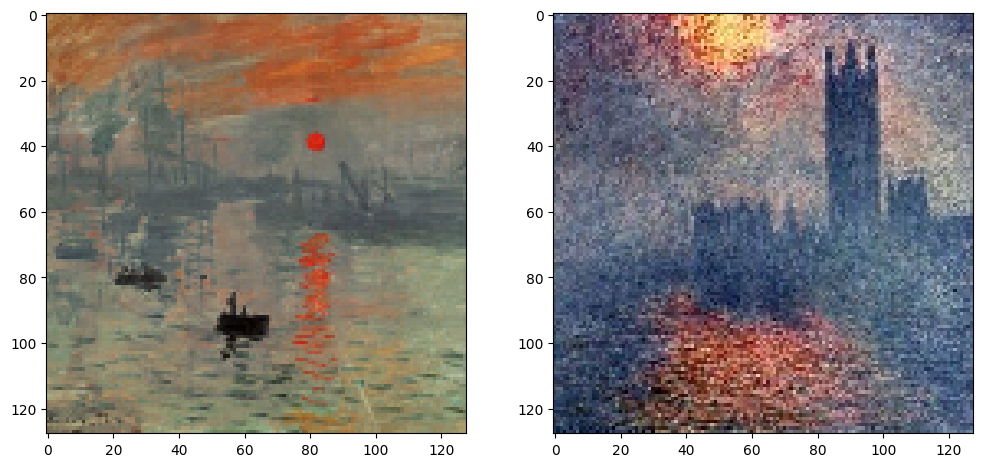

In [12]:

fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
display_image(ax,Y)
ax = fig.add_subplot(2,2,2)
display_image(ax,X1)

# plt.savefig('result01.png')

# ax = fig.add_subplot(2, 2, 3, projection="3d")
# display_cloud(ax, X)
# ax.set_title("Source point cloud")
# ax = fig.add_subplot(2, 2, 4, projection="3d")
# display_cloud(ax, X1)
# ax.set_title("Target point cloud")
# plt.tight_layout()

In [13]:
@ interact(i = (0,75))



def plot_int(i):
    fig = plt.figure(figsize=(12,12))
    linear_int = (1-i/75)*X+i/75*X1
    ax = fig.add_subplot(2,2,1)
    display_image(ax,linear_int)

interactive(children=(IntSlider(value=37, description='i', max=75), Output()), _dom_classes=('widget-interact'…

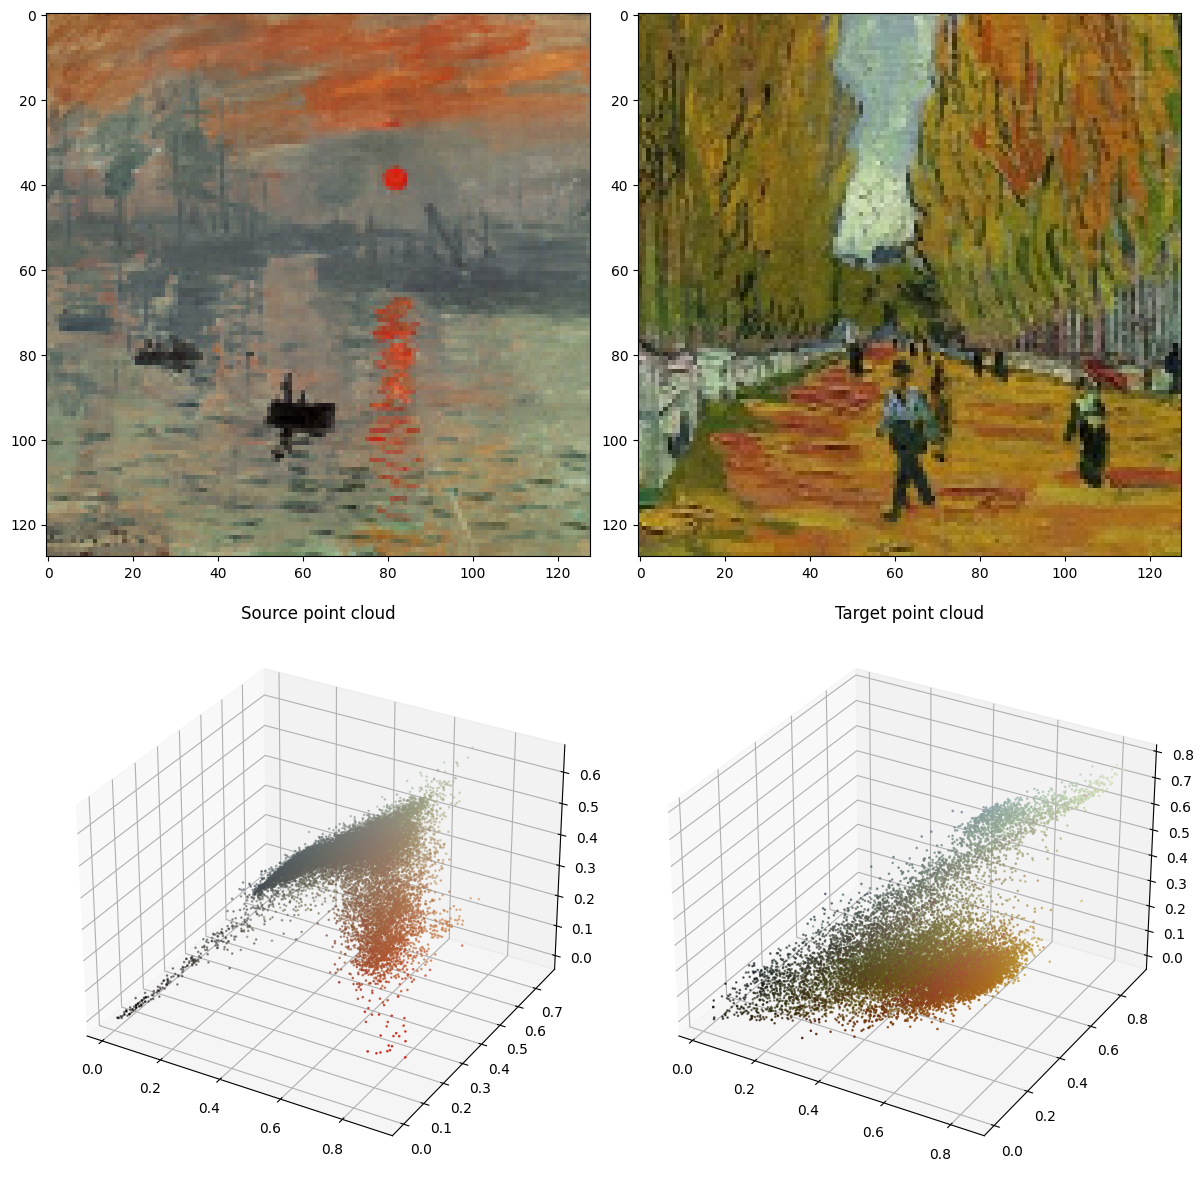

In [14]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
display_image(ax,Y)
ax = fig.add_subplot(2,2,2)
display_image(ax,Z)

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, Y)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, Z)
ax.set_title("Target point cloud")
plt.tight_layout()

# plt.savefig('target12.png')

In [15]:
C12 = cost_mat(Y.T,Z.T,n)

In [16]:
row_ind12, col_ind12 = linear_sum_assignment(C12)

In [66]:
Y1 = Z[col_ind12]

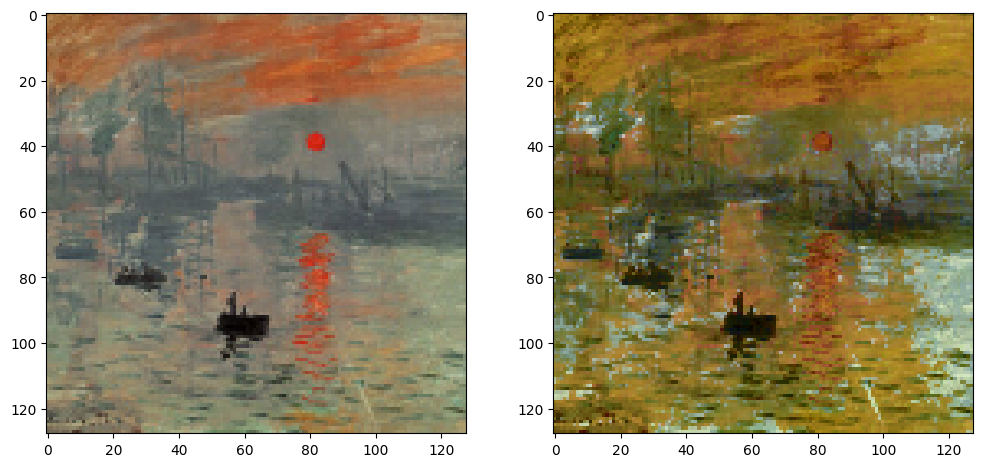

In [69]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
display_image(ax,Y)
ax = fig.add_subplot(2,2,2)
display_image(ax,Y1)

# plt.savefig("result12.png")



In [71]:
@ interact(i = (0,75))



def plot_int(i):
    fig = plt.figure(figsize=(12,12))
    linear_int = (1-i/75)*Y+i/75*Y1
    ax = fig.add_subplot(2,2,1)
    display_image(ax,linear_int)
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    display_cloud(ax, linear_int)
    ax.set_title("Source point cloud")

interactive(children=(IntSlider(value=37, description='i', max=75), Output()), _dom_classes=('widget-interact'…

In [74]:
K = 250

@ interact(i = (0,K))



def plot_int(i):
    fig = plt.figure(figsize=(12,12))
    linear_int01 = (1-i/K)*X+i/K*X1
    linear_int12 = (1-i/K)*Y+i/K*Y1
    linear_int02 = (1-i/K)*linear_int01 + i/K*linear_int12
    ax = fig.add_subplot(2,2,1)
    display_image(ax,linear_int02)
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    display_cloud(ax, linear_int02)
    ax.set_title("Source point cloud")

interactive(children=(IntSlider(value=125, description='i', max=250), Output()), _dom_classes=('widget-interac…

# Flow from 0 to 2

In [75]:
C02 = cost_mat(X.T,Z.T,n)
row_ind02, col_ind02 = linear_sum_assignment(C02)

In [77]:
X2 = Z[col_ind02]

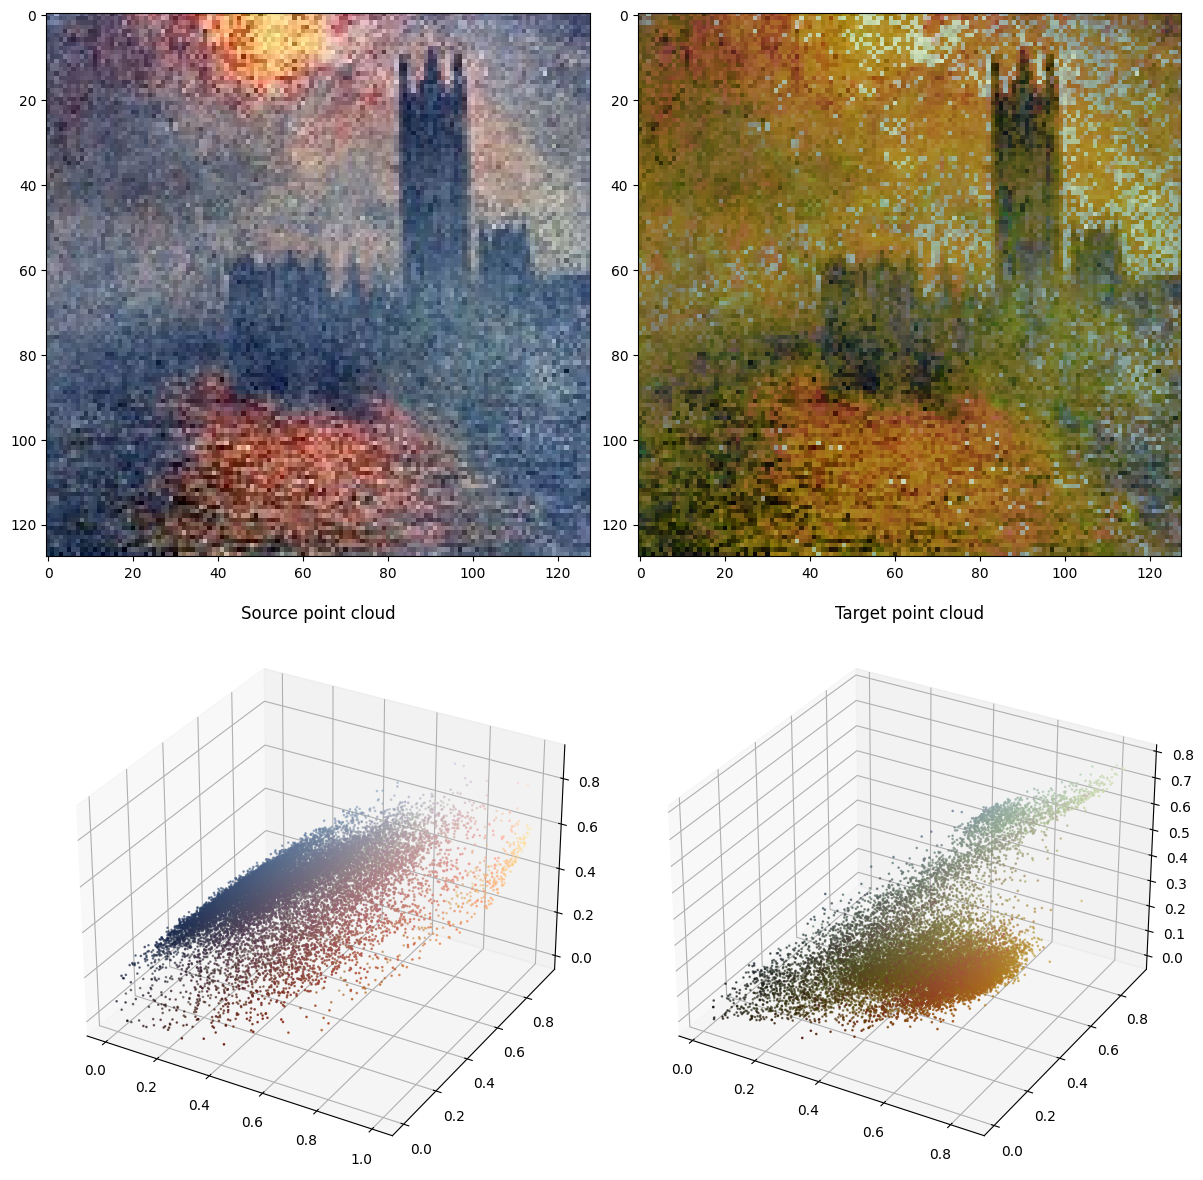

In [81]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
display_image(ax,X)
ax = fig.add_subplot(2,2,2)
display_image(ax,X2)

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, X)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, X2)
ax.set_title("Target point cloud")
plt.tight_layout()

In [93]:
K = 50

@ interact(i = (0,K))



def plot_int(i):
    fig = plt.figure(figsize=(12,12))
    linear_int01 = (1-i/K)*X+i/K*X1
    linear_int12 = (1-i/K)*X1+i/K*X2
    linear_int02 = (1-i/K)*linear_int01 + i/K*linear_int12
    ax = fig.add_subplot(1,2,1)
    display_image(ax,linear_int02)
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    display_cloud(ax, linear_int02)
    ax.set_title("Source point cloud")
    plt.savefig('transport02_{:d}.png'.format(i))

interactive(children=(IntSlider(value=25, description='i', max=50), Output()), _dom_classes=('widget-interact'…

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>